In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, parallel_backend
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

### We are defining some functions for preprocessing, cleaning and data structuring purposes

In [2]:
def clean_text(text):
    ''' 
    Some basic text cleaning phases this function should be applied to the text column
    of the data
    '''
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    stop = [w for w in stop if w not in ['not', 'no']]
    text = [x for x in text if (x not in stop)]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    # tokenize the text
    #text = text.split()
    return(text)
def apply_cleaning(X_train):
    '''
    With this fonction we apply the clean_text function to the text column of the data
    and it gives as output the cleaned data for each row of the text column
    '''
    X_train = X_train.apply(lambda x: clean_text(x))
    return(X_train)

def tfidf_featured_data(X_train):
    ''''
    No need to explain this function because we gonna use it in the pipeline automatically this function
    used to add tf-idfs columns to the data but I used this to play around with the data and see the
    results of the tfidf vectorizer
    '''

    X_train = apply_cleaning(X_train)
    # add tf-idfs columns
    tfidf = TfidfVectorizer(min_df = 30)
    tfidf_result = tfidf.fit_transform(X_train).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = X_train.index
    X_train = pd.concat([X_train, tfidf_df], axis=1)
    X_train.drop(columns = ['sentences'], inplace = True)
    
    return X_train

def dict2text(dicti):
    '''
    This function is used to convert the dictionary of parameters to a string
    used for GridsearchCV outputs to be saved in a csv file and to be used later 
    on project.
    '''
    text = ''
    for key, value in dicti.items():
        text += str(key) + '=' + str(value) + ' '
    return text

def format_params(params_str):
    '''
    I captured some differences between the parameters of the GridsearchCV output
    to standardize it and make it easy to be used later on the project.
    '''
    # Remove the opening and closing braces and quotes
    params_str = params_str.replace("{", "").replace("}", "").replace("'", "")

    # Replace commas with spaces
    params_str = params_str.replace(", ", " ")

    # Replace colons with equals signs
    params_str = params_str.replace(":", "=")

    # Remove spaces around equals signs
    params_str = params_str.replace("= ", "=").replace(" =", "=")

    return params_str

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def roc_auc(test, y_pred):
    # Assuming y_true contains the true labels (0 or 1) and y_pred contains the predicted probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(test.values, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

##### As a baseline model Naive Bayes is the perfect model. It is time efficient and good performing. Also there are not much parameters to play around so we are able to focus on feature creation phase. 

In [4]:
train = pd.read_csv('train_data_400k_randomsample.csv')
train["sentences"] = apply_cleaning(train["sentences"])

In [1]:
X_train = train["sentences"]
y_train = train["label"]

# Create the Naive Bayes pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])


param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Vary the n-gram range
    'tfidf__use_idf': [True, False],  # Vary the use of IDF
    'classifier__alpha': [0.1, 1.0, 10.0] # Vary the smoothing parameter (alpha)
}


# Split the current slice into train and test sets
    
# Create a GridSearchCV object for each pipeline
grid_search= GridSearchCV(pipeline, param_grid, cv=3, verbose=3)


# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = grid_search.predict(X_test)

# Calculate the accuracy score for the current slice
score = accuracy_score(y_test, y_pred)

# Print the accuracy score and best hyperparameters for the current slice
print("Accuracy score: ", score)
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

NameError: name 'train' is not defined

In [17]:
grid_search.best_params_

{'classifier__alpha': 0.1,
 'tfidf__use_idf': False,
 'vectorizer__ngram_range': (1, 2)}

#### After selecting the best parameters our model with 400k train data and 44k test data being evaluated. And confusion matrix has been produced. 

In [3]:
train = pd.read_csv("train_data_400k_randomsample.csv")
train["sentences"] = apply_cleaning(train["sentences"])
test = pd.read_csv(("test_data_44k.csv"))
test["sentences"] = apply_cleaning(test["sentences"])

In [4]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('classifier', MultinomialNB(alpha=0.1,))
])

pipeline.fit(train["sentences"], train["labels"])

y_pred = pipeline.predict(test["sentences"])
pd.DataFrame(y_pred).to_csv("y_pred_tf-idf-NaiveBayes.csv")

accuracy_score = accuracy_score(test["labels"], y_pred)
f1_score = f1_score(test["labels"], y_pred)
roc_auc_score = roc_auc_score(test["labels"], y_pred)
precision_score = precision_score(test["labels"], y_pred)
recall_score = recall_score(test["labels"], y_pred)

print("Accuracy score: ", accuracy_score)
print("F1 score: ", f1_score)
print("ROC AUC score: ", roc_auc_score)
print("Precision score: ", precision_score)
print("Recall score: ", recall_score)


Accuracy score:  0.8935454545454545
F1 score:  0.8921035658343315
ROC AUC score:  0.893519276949668
Precision score:  0.9022037925732657
Recall score:  0.8822269807280514


AUC: 0.9590


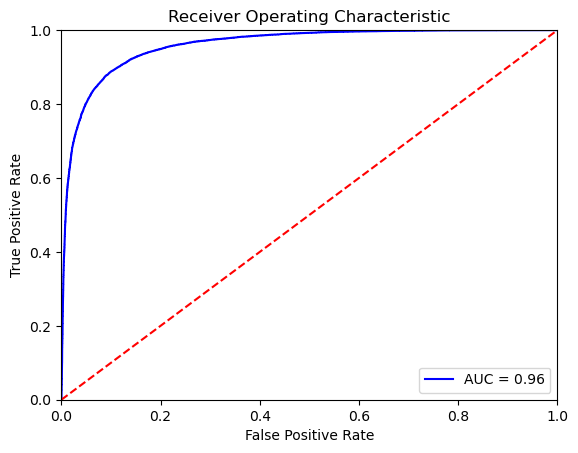

In [5]:
y_pred_probs = pipeline.predict_proba(test["sentences"])
pd.DataFrame(y_pred_probs).to_csv("y_pred_probs_tf-idf-NaiveBayes.csv")

def evaluate_roc_probs(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true),)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Evaluate ROC curve
evaluate_roc_probs(y_pred_probs[:, 1], test["labels"].values)

#### Error Analysis

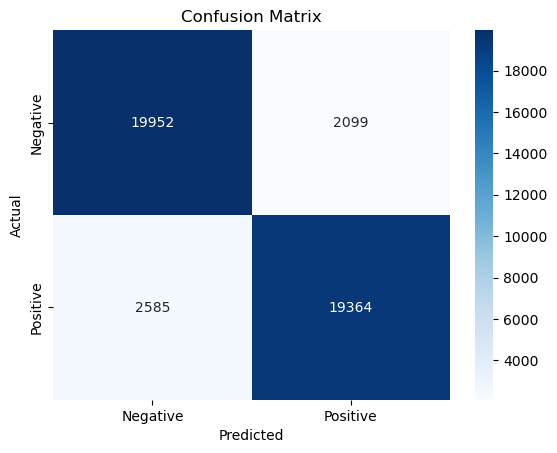

In [21]:
#Show confusion matrix
cm = confusion_matrix(test["labels"], y_pred)
cm = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


<AxesSubplot: xlabel='labels'>

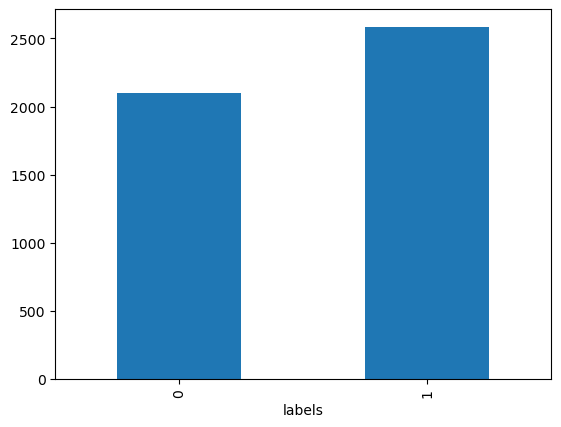

In [22]:
test = pd.read_csv(("test_data_44k.csv"))
test["y_pred"] = y_pred
test[test["labels"] != test["y_pred"]].groupby('labels').count()["sentences"].plot(kind="bar")

In [25]:
# Select the 5 random observations from the test set where model failed to predict the label correctly

pd.set_option('display.max_colwidth', None)
# test[test["labels"] != test["y_pred"]].sample(5)
indices = [27443, 29215, 14827 ,18809 ,12847]
test[test.index.isin(indices)]

,sentences,labels,y_pred
12847,"a good book: this book really hit the mark with the right balance of theory and practical application. i've waded through more than a few technical books on tube radio theory and restoration, and this one, though not as detailed as a textbook, is clearly the place to start.however, the section on troubleshooting was extremely limited. experience indicates that after following the steps recommended in the book between 10 and 20 percent of restored radios will still have some type of problem. most individuals learning the process for repairing tube radios will be seeking practical guidance for identifying possible sources of these problems and their potential solutions. maybe troubleshooting will be the subject of mr. mcwhorter's next book.",1,1
14827,"here is just a sample!! check it out!!: i love this album and pray that someone contacts me so that i can get a copy of the cd or even tape! amazon...please get this so that all of us who would like a copy can get it! until then...here is ""feel like going on"" the song![...]",1,1
18809,"still in the box: i don't really know how the product is. after reading more detailed information included with the product, it says not recommended for the pool because the clorine could effect/shorten the product life. it seems that the ad shows the coolaroo shade being used next to the pool. and that's what we bought it for. not sure what to do with them now - still siting in the box next to the door gathering dust.... oh, well. i'm sure its a great product, just not for us.",0,0
27443,"leaves the readers hungry for more.: it's weird really how i got so into this book. one of my friends who just so happened read the book was begging me to read it. now, don't get me wrong i love fantasy stories especially ones that are about these blood suckers but after hearing my friend's summary of it i don't know i just felt uninterested.pffft...boy was i glad my friend's the persisting type. she practically lunged the book at me. so as to not annoy her more, i read her copy of the book and i found myself entralled by it. i could not stop reading it!after finishing it i felt saddened that it was finished. i wanted more! i wanted to know what happened next.i gave the book back to my friend and straight away got myself a copy of twilight. it's really that good. i love it.trust me no matter how 'off' the summary might seem like you would not feel dissatisfied by its contents.",1,0
29215,"emotionally-distant author: for a memoir, the author is very removed from the experiences she writes about. she conveys little if any emotion about what must have been a very lonely and often frightening existance (especially given her age) in a strange land with a mad and eventually abusive husband, a young child who was often extremely sick and with the responsibilites of running a hacienda. although her writing is beautiful at times, the author never really connected with me.",0,1


In [26]:
pd.set_option('display.max_colwidth', None)
test[test["labels"] != test["y_pred"]].sample(5)

,sentences,labels,y_pred
10772,"not worth the wait at all!: all i can say is that this book was a dissapointment. it seems to be the same plot over and over again from the other book except it's lacking a lot on the emotional level. most of the books that mrs. feehan have written over the years all have nearly the same plotting but at least the characters in those other books are more well define. yes, the book had plenty of fighting (too much in my opinion), plenty of sex scenes but the love just wasn't that well portray. all in all, an unsastisfied read. not to mention i waited four months for this. just hope her upcoming books such as dark celebration and dark possession holds more elements of a paranormal romance novel.",0,1
18081,"not sure . . .: i read this book with some enjoyment. the writing was good. the story kept me interested and reading, but when i reached the end, i felt disturbed and unsatisfied. i did not like the ultimate let down the main character gave me. however, because i found the writing very good, i am going try another book by this auther and hope for a more satisfying end.",1,0
21350,"bye bye comcast!: i bought a sharp aquos before christmas and recently started exploring ota hdtv. when i bought my house there was an antenna in the attic (a classic vhf/uhf antenna), so i hooked that up to the tv to see what channels i could get. unfortunately, my local fox affiliate would not tune and my local nbc station was intermittent--they are both about 35-40 miles away.i first tried switching to a ""hd"" antenna, but this was worse than the classic antenna.then i hooked up the signal booster. suddenly, i have all of my locals plus a few i didn't even know existed. the signal is perfect and a lot of the signals are even stronger than what i was getting over a cable from comcast! i can even now get one station which is located approximately 180 degrees from where the antenna is pointed--although this station is only about 12 miles away.anyway, at the end of the month i am cancelling my comcast subscription since i now have crystal clear hd for free!",1,0
30676,"classic baby toy but ugly packaging: i ordered this as a gift - the product was as pictured, but is came in a really ugly cardboard box. being that the gift was for a baby, i was hoping for more attractive packaging - otherwise it was a nice gift.",1,0
15482,"(not u-13, but didn't have an account.): green day has totally mainstream with this album, which disappointed me. new fans who have never heard green day before will love the new green day, and hate the old green day because their older music is much different than this new album. i am extremely disappointed, for this album is pure pop-punk and none of the songs are even really that good. green day has sold out with this album. check out their older albums, they are much better worth listening to if you like real punk music.",0,1


It seems that our Naive Bayes model is able to classify negative sentiments better than positive ones. One reason is that usually negative sentences consists of negative words dominantly in terms of purity but the positive reviews often embedded with negative words which are referring to the features of the product that aren't appreciated by the reviewer eventhough product in general liked by the reviewer. This situation often caused by the lack of full contextual understanding over the sentence. However those models are not relly designed to understand semantics of the reviews using ngram still helps us to capture some contextual connections between words.